# Assignment 3

### Jacob Schreck

In [233]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from statsmodels.stats.multitest import multipletests
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from itertools import combinations

### 1. Load the expression and meta data from Assignment 2

In [13]:
expression_df = pd.read_csv(r'..\data\SRP092257\data_with_gene_names.tsv', sep='\t')

In [165]:
metadata_df = pd.read_csv(r'..\data\SRP092257\metadata_SRP092257.tsv', sep='\t')

In [179]:
# If 'Gene' column is not properly detected, handle it manually
if 'Gene' not in expression_df.columns:
    # Manually set the first column as 'Gene' if needed
    expression_df.columns = ['Gene'] + expression_df.columns[1:].tolist()

# Set 'Gene' as the index
if 'Gene' in expression_df.columns:
    expression_df.set_index('Gene', inplace=True)
    

In [181]:
# Assign sample groups based on 'refinebio_title'
def assign_group(title):
    if 'Control' in title:
        return 'Thermoneutral'
    elif 'Heat Stress' in title:
        return 'Affected by Heat'
    else:
        return 'Unknown'  # Just in case there's anything unexpected

# Create 'Group' column in metadata
metadata_df['Group'] = metadata_df['refinebio_title'].apply(assign_group)


In [191]:
# Ensure sample names match between expression data and metadata

# Get sample names from expression data
expression_samples = expression_df.columns.tolist()  # Assuming 'Gene' is the index

# Get sample names from metadata using the index
metadata_samples = metadata_df.index.tolist()

# Check for missing samples
missing_samples_in_metadata = set(expression_samples) - set(metadata_samples)
if missing_samples_in_metadata:
    print(f"Warning: The following samples are missing in metadata: {missing_samples_in_metadata}")
else:
    print("All expression samples are present in metadata.")

missing_samples_in_expression = set(metadata_samples) - set(expression_samples)
if missing_samples_in_expression:
    print(f"Warning: The following samples are missing in expression data: {missing_samples_in_expression}")
else:
    print("All metadata samples are present in expression data.")


All expression samples are present in metadata.


### 2. Unsupervised Analysis (e.g. using TidyClust in R or scikit-learn in Python)


#### a. Subset your data to the 5,000 most variable genes

In [119]:
if 'Gene' in expression_df.columns:
    expression_df.set_index('Gene', inplace=True)

In [121]:
gene_variances = expression_df.var(axis=1)

top_5000_genes = gene_variances.nlargest(5000).index
subset_expression = expression_df.loc[top_5000_genes]

In [123]:
#transpose to have samples as rows and genes as cols
subset_expression_T = subset_expression.T

#standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(subset_expression_T)

#### b. Using that subset of the data, select and run a clustering algorithm from this list: Hierarchical clustering (e.g. hclust)


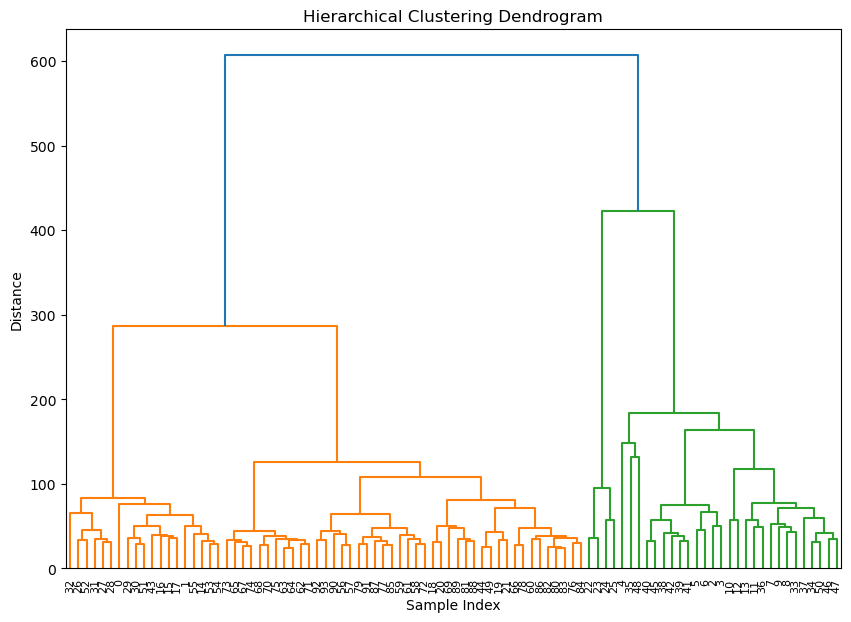

In [108]:
# Hierarchical clustering
# linkage method can be 'single', 'complete', 'average', or 'ward' (ward is most commonly used)
Z = linkage(X_scaled, method='ward')

# Plot the dendrogram to visualize the clustering hierarchy
plt.figure(figsize=(10, 7))
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [127]:
# Create a DataFrame to store cluster results for different cuts of the dendrogram
cluster_results = pd.DataFrame(index=subset_expression_T.index)

# Loop over different number of clusters, k, from 2 to 10
for k in range(2, 11):
    # fcluster with criterion='maxclust' finds exactly 'k' clusters
    clusters = fcluster(Z, k, criterion='maxclust')
    cluster_results[f'k_{k}'] = clusters

# Compare cluster memberships for k=2 and k=3 (similar to your K-means example)
contingency_table = pd.crosstab(cluster_results['k_2'], cluster_results['k_3'])
print(contingency_table)

k_3   1  2   3
k_2           
1    63  0   0
2     0  4  27


In [129]:
# Z is the linkage matrix from your hierarchical clustering
# The 4th column (Z[:, 2]) contains the distances at which clusters are merged
heights = Z[:, 2]

# Find the height at which the number of clusters is 2 and 3
print("Height for k=2:", heights[-2])  # second-to-last merge
print("Height for k=3:", heights[-3])  # third-to-last merge

Height for k=2: 422.92006851850056
Height for k=3: 286.7088314122514


#### d. How many clusters did your method find?

I found that there are 2 distinct clusters if cut off at a height of 300. However, if the height is cut off at a lower height of 100 there are about 4 -5 clusters.

##### i. If you ran a method that requires you to select the number of clusters (k), how did changing this value change the results? Compare cluster membership at each k to investigate this

When changing from K=2 to K=3 the second clusters split into two smaller clusters and the first one stayed the same. This shows that the first cluster is more cohesive while the second one is less cohesive and split apart when increasing K.

##### ii. If you ran a method that selects k for you, describe why it chose that k. Vary the method parameters to get different numbers of cluster. How did these changes impact your results?

The method I chose to use does not select k for me and instead the k number of clusters is based on the height cutoff that I decided. The height cutoff is about 430 for k=2 and about 300 for k=3.

#### e. Rerun each clustering method using different numbers of genes. Try 10, 100, 1000, and 10000 genes.

In [197]:
# List of different numbers of genes to use
gene_numbers = [10, 100, 1000, 10000]

# Calculate gene variances (genes are in index)
gene_variances = expression_df.var(axis=1)

# Initialize a DataFrame to store clustering results
cluster_results_genes = pd.DataFrame(index=expression_df.columns)  # Samples are in the columns

for num_genes in gene_numbers:
    # Ensure the number of genes does not exceed the total available
    num_genes = min(num_genes, len(gene_variances))
    
    # Select the top 'num_genes' most variable genes
    top_genes = gene_variances.nlargest(num_genes).index
    
    # Subset the expression data to these genes (genes are in the index)
    subset = expression_df.loc[top_genes]  # Subset to top genes (genes x samples)
    
    # Transpose to get samples as rows and genes as columns
    subset = subset.T  # Now, shape is (samples x genes)
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(subset)
    
    # Perform hierarchical clustering
    Z = linkage(X_scaled, method='ward')
    
    # Extract cluster labels (e.g., for 3 clusters)
    clusters = fcluster(Z, 3, criterion='maxclust')
    
    # Store the cluster labels in the DataFrame
    cluster_results_genes[f'genes_{num_genes}'] = clusters


##### i. Compare your results. How did the number of genes affect clustering?

With the small number of genes like 10 and 100 there were simplier clusters that are clearer to see. However, it was lacking detail and missing more specific variation information because of the simplification.

With gene count at 1,000 there were more balanced clustering with a good amount of informative cluster spread and showed specific subgroups within the clusters.

With gene count at 10,000 there were a lot more subtle specific groups within the samples and showed multiple subclusters compared to the lesser amounts of gene samples. Although there are more details to observe there is also too much and many clusters are very small and lead to vague variation between the specific subclusters.

##### ii. To do this, perform a chi-squared test on each pair of clustering results. Provide these results in a table in your writeup.

In [66]:
from scipy.stats import chi2_contingency
# Compare clustering results between different gene counts using a chi-squared test
chi2_results = []

for i in range(len(gene_numbers)):
    for j in range(i + 1, len(gene_numbers)):
        # Get the cluster labels for the two gene counts
        clusters_i = cluster_results_genes[f'genes_{gene_numbers[i]}']
        clusters_j = cluster_results_genes[f'genes_{gene_numbers[j]}']
        
        # Create a contingency table
        contingency_table = pd.crosstab(clusters_i, clusters_j)
        
        # Perform the chi-squared test
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        
        # Store the results
        chi2_results.append({
            'Comparison': f'{gene_numbers[i]} vs {gene_numbers[j]}',
            'Chi2': chi2,
            'Degrees of Freedom': dof,
            'p-value': p
        })

# Convert to a DataFrame to display the results
chi2_df = pd.DataFrame(chi2_results)
print(chi2_df)

      Comparison        Chi2  Degrees of Freedom       p-value
0      10 vs 100  152.024691                   4  7.495801e-32
1     10 vs 1000  188.000000                   4  1.425746e-39
2     10 vs 5000  188.000000                   4  1.425746e-39
3    10 vs 10000  188.000000                   4  1.425746e-39
4    100 vs 1000  152.024691                   4  7.495801e-32
5    100 vs 5000  152.024691                   4  7.495801e-32
6   100 vs 10000  152.024691                   4  7.495801e-32
7   1000 vs 5000  188.000000                   4  1.425746e-39
8  1000 vs 10000  188.000000                   4  1.425746e-39
9  5000 vs 10000  188.000000                   4  1.425746e-39


##### iii. Create an alluvial diagram (Sankey plot) to visualize how the different clustering setups changed cluster memberships for each sample. Each column should be 1 clustering result, and the samples create the ribbons/layers.

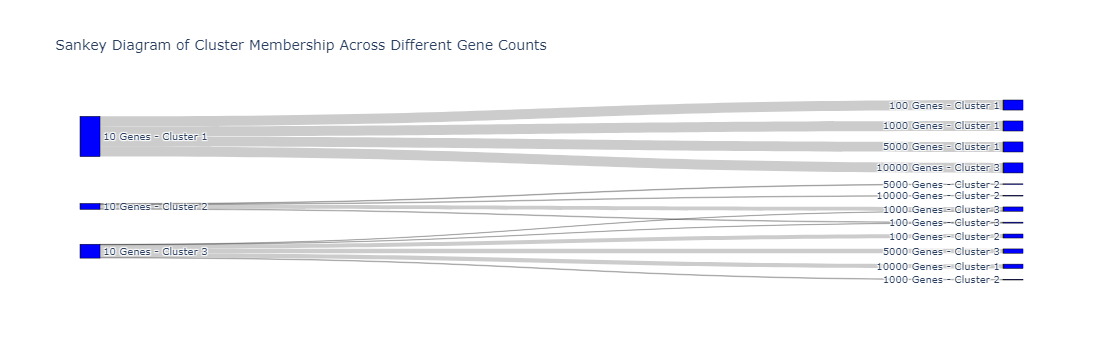

In [68]:
# Prepare data for Sankey diagram (source, target, value)
source = []
target = []
value = []

# Loop through gene numbers to track how samples move between clusters
for i in range(len(gene_numbers) - 1):
    contingency_table = pd.crosstab(cluster_results_genes[f'genes_{gene_numbers[i]}'],
                                    cluster_results_genes[f'genes_{gene_numbers[i+1]}'])
    
    for row in contingency_table.index:
        for col in contingency_table.columns:
            if contingency_table.loc[row, col] > 0:
                source.append(row - 1)  # Adjust to start at index 0
                target.append(col - 1 + (i + 1) * 3)  # Adjust target to next set of clusters
                value.append(contingency_table.loc[row, col])

# Create labels for the nodes (clusters at different gene counts)
labels = []
for count in gene_numbers:
    labels.extend([f'{count} Genes - Cluster {i}' for i in range(1, 4)])  # 3 clusters at each step

# Create the Sankey diagram
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,  # Label the nodes with the gene count and cluster number
        color="blue"
    ),
    link=dict(
        source=source,  # Indices correspond to labels, starting from 0
        target=target,  # Targets are the next cluster labels
        value=value     # The number of samples moving between clusters
    ))])

fig.update_layout(title_text="Sankey Diagram of Cluster Membership Across Different Gene Counts", font_size=10)
fig.show()


### 3. Heatmaps and Dendrograms

#### a. Create a heatmap of the 5,000 genes used in clustering. Add an annotation sidebar showing one set of clusters you identified from each clustering method and the sample groups from Assignment 1.

In [114]:
if 'Group' in metadata_df.index.names:
    print("'Group' is in the index.")
else:
    print("'Group' is not in the index.")

# Print index names
print("Index names:", metadata_df.index.names)


'Group' is not in the index.
Index names: ['refinebio_accession_code']


In [177]:
# Use the top 5,000 most variable genes
gene_variances = expression_df.var(axis=1)
top_genes = gene_variances.nlargest(5000).index
subset_expression = expression_df.loc[top_genes].T

# Transpose to have samples as rows
subset_expression_T = subset_expression.T

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(subset_expression_T)

# **Step 2: Perform Hierarchical Clustering**

# Perform hierarchical clustering on samples
Z = linkage(X_scaled, method='ward')

# Assign clusters (e.g., 3 clusters)
clusters = fcluster(Z, 3, criterion='maxclust')

# Create cluster assignments DataFrame
cluster_assignments = pd.DataFrame({'Cluster': clusters}, index=subset_expression_T.index)

# **Step 3: Prepare Annotations**

# Ensure indices are aligned and of the same type
cluster_assignments.index = cluster_assignments.index.astype(str)
metadata_df.index = metadata_df.index.astype(str)

# Merge cluster assignments with metadata_df on the index
annotations = cluster_assignments.merge(metadata_df[['Group']], left_index=True, right_index=True, how='left')


In [121]:
# Create a color palette for clusters
cluster_palette = sns.color_palette('hsv', len(annotations['Cluster'].unique()))
cluster_lut = dict(zip(sorted(annotations['Cluster'].unique()), cluster_palette))
cluster_colors = annotations['Cluster'].map(cluster_lut)

# Step 3: Assign Colors to Groups

# Create a color palette for groups
group_palette = sns.color_palette('Set2', len(annotations['Group'].unique()))
group_lut = dict(zip(annotations['Group'].unique(), group_palette))
group_colors = annotations['Group'].map(group_lut)

# Step 4: Combine Colors into a DataFrame

row_colors = pd.DataFrame({'Cluster': cluster_colors, 'Group': group_colors}, index=annotations.index)


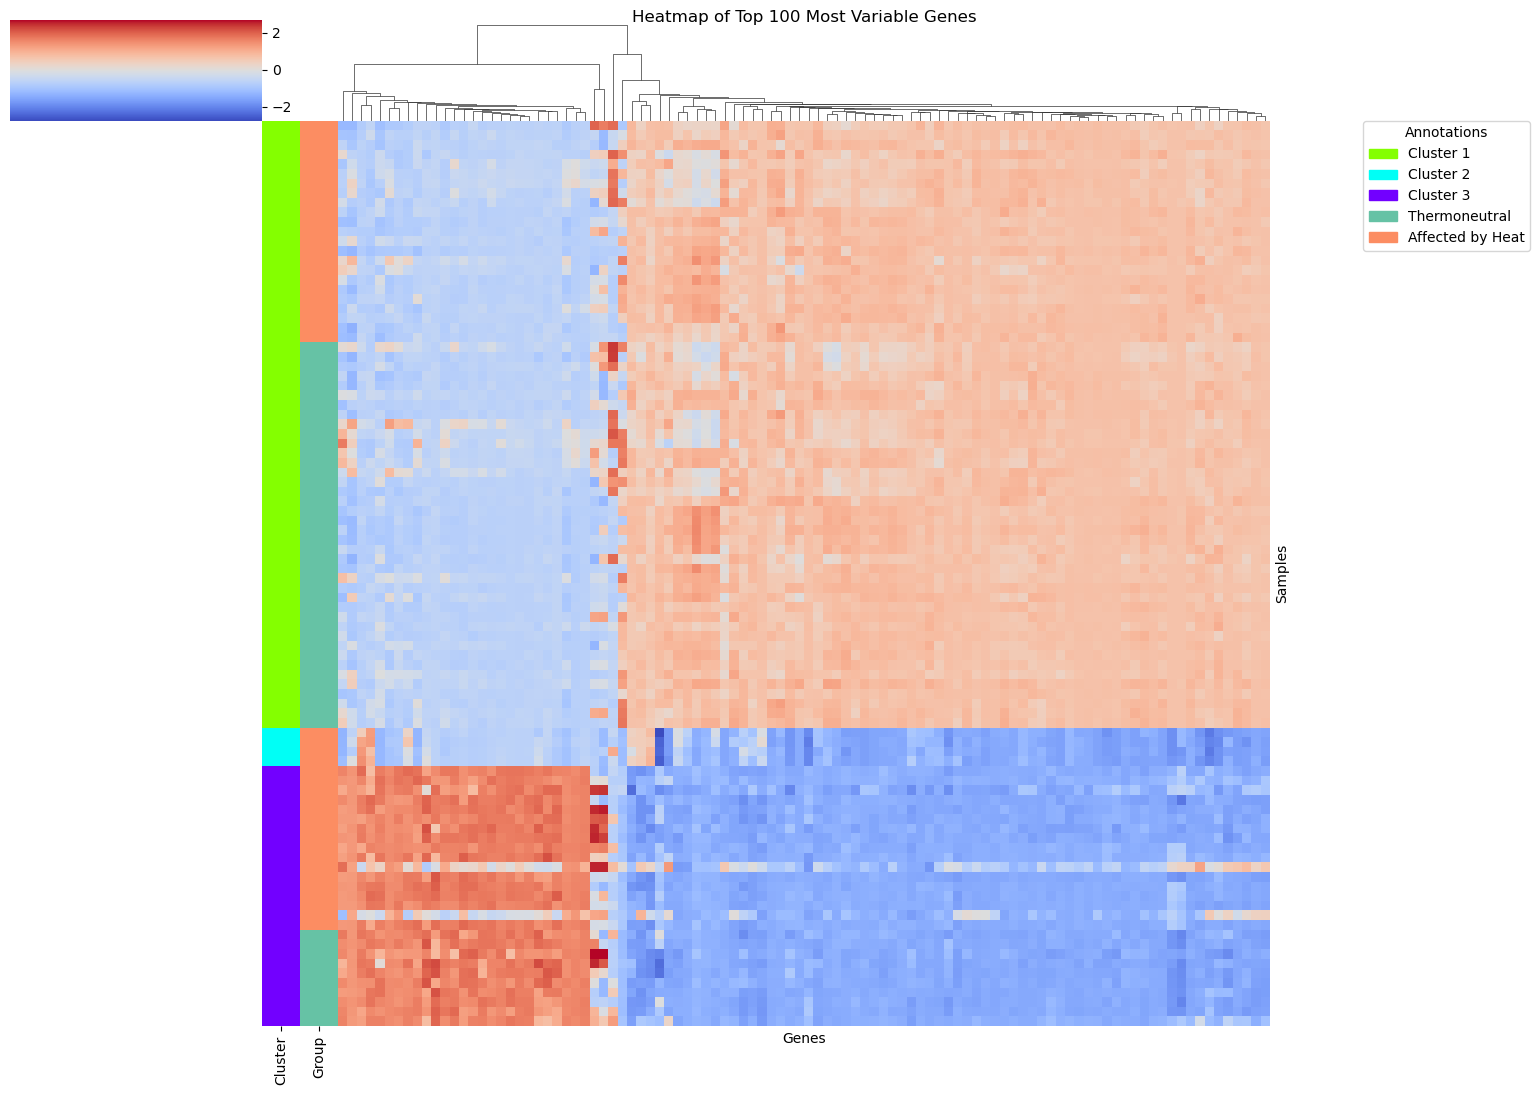

In [149]:
# For visualization purposes, select the top 100 most variable genes
gene_variances = expression_df.var(axis=1)
top_genes = gene_variances.nlargest(100).index
subset_expression = expression_df.loc[top_genes].T

# Standardize the data
scaler = StandardScaler()
X_scaled_subset = scaler.fit_transform(subset_expression)

# Create standardized DataFrame
subset_expression_T_standardized = pd.DataFrame(
    X_scaled_subset,
    index=subset_expression.index,
    columns=subset_expression.columns
)

# Step 6: Sort Data Based on Annotations

# Sort the annotations DataFrame based on Cluster and Group
annotations_sorted = annotations.sort_values(['Cluster', 'Group'])

# Reorder the expression data and row_colors accordingly
subset_expression_T_standardized = subset_expression_T_standardized.loc[annotations_sorted.index]
row_colors = row_colors.loc[annotations_sorted.index]

# Step 7: Plot the Clustermap with Adjustments

g = sns.clustermap(
    subset_expression_T_standardized,
    row_colors=row_colors,
    col_cluster=True,   # Cluster columns (genes)
    row_cluster=False,  # Do not cluster rows (samples)
    figsize=(15, 12),
    cmap='coolwarm',    # Choose a diverging colormap
    xticklabels=False,   # Show gene labels
    yticklabels=False,   # Hide sample labels for clarity
    dendrogram_ratio=(0.2, 0.1),  # Adjust dendrogram sizes
    cbar_pos=(0.02, 0.8, 0.02, 0.18)  # Adjust colorbar position
)



# Adjust the position of the colorbar
g.cax.set_position([0.95, 0.2, 0.03, 0.45])  # [left, bottom, width, height]

# Create legend handles for clusters
cluster_labels = sorted(annotations['Cluster'].unique())
cluster_handles = [mpatches.Patch(color=cluster_lut[label], label='Cluster ' + str(label)) for label in cluster_labels]

# Create legend handles for groups
group_labels = annotations['Group'].unique()
group_handles = [mpatches.Patch(color=group_lut[label], label=label) for label in group_labels]

# Combine handles
handles = cluster_handles + group_handles
labels = [handle.get_label() for handle in handles]

# Add legend to the heatmap
g.ax_heatmap.legend(
    handles=handles,
    labels=labels,
    title='Annotations',
    loc='upper left',
    bbox_to_anchor=(1.1, 1),
    borderaxespad=0.,
    frameon=True
)

# Add axis labels and title
g.ax_heatmap.set_xlabel('Genes')
g.ax_heatmap.set_ylabel('Samples')
g.ax_heatmap.set_title('Heatmap of Top 100 Most Variable Genes', y=+1.1)

# Adjust layout to prevent clipping of legend and labels
plt.subplots_adjust(right=0.85, top=0.9)

plt.show()

### 4. Statistics

#### a. Does cluster membership correlate with the groups you chose in Assignment 1? Perform a chi-squared test of independence to statistically compare the two . Repeat this for each clustering result. Add these results to your table of chi-squared test results.

Yes, the cluster memberships correlates with the groups chosen in Assignment 1. The clusters show association with the sample groups:Thermoneutral and Affected by heat.

In [156]:
# Assuming 'X_scaled' is the standardized data from your clustering
Z = linkage(X_scaled, method='ward')
clusters_2 = fcluster(Z, 2, criterion='maxclust')

# Create a DataFrame with cluster assignments
cluster_assignments_2 = pd.DataFrame({'Cluster': clusters_2}, index=subset_expression_T.index)

# Merge with sample groups
annotations_2 = cluster_assignments_2.merge(metadata_df[['Group']], left_index=True, right_index=True, how='left')

# Create contingency table
contingency_table_2 = pd.crosstab(annotations_2['Cluster'], annotations_2['Group'])

# Perform chi-squared test
chi2_2, p_value_2, dof_2, expected_2 = chi2_contingency(contingency_table_2)

In [158]:
# Perform hierarchical clustering with 3 clusters
clusters_3 = fcluster(Z, 3, criterion='maxclust')

# Create a DataFrame with cluster assignments
cluster_assignments_3 = pd.DataFrame({'Cluster': clusters_3}, index=subset_expression_T.index)

# Merge with sample groups
annotations_3 = cluster_assignments_3.merge(metadata_df[['Group']], left_index=True, right_index=True, how='left')

# Create contingency table
contingency_table_3 = pd.crosstab(annotations_3['Cluster'], annotations_3['Group'])

# Perform chi-squared test
chi2_3, p_value_3, dof_3, expected_3 = chi2_contingency(contingency_table_3)


In [173]:
# Assuming you have your results DataFrame
results = pd.DataFrame({
    'Method': ['Hierarchical (2 Clusters)', 'Hierarchical (3 Clusters)'],
    'Chi-squared Statistic': [chi2_2, chi2_3],
    'Degrees of Freedom': [dof_2, dof_3],
    'P-value': [p_value_2, p_value_3]
})


#### b. Adjust all statistical test results for multiple hypothesis testing (p.adjust).

In [171]:
# Adjust p-values
p_values = results['P-value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Add adjusted p-values and rejection decisions to the results DataFrame
results['Adjusted P-value'] = pvals_corrected
results['Reject Null Hypothesis'] = reject

# **Set display options to show all columns**
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [168]:
# Display the results table
print(results.to_string(index=False))

                   Method  Chi-squared Statistic  Degrees of Freedom  P-value  Adjusted P-value  Reject Null Hypothesis
Hierarchical (2 Clusters)               6.934573                   1 0.008455          0.008455                    True
Hierarchical (3 Clusters)              10.060125                   2 0.006538          0.008455                    True


### 5. Short Summary


In this assignment I used an unsupervised clustering method: hierarchical clustering, in order to identify clusters that display the differences between the expereimental groups. The heatmap visualization and statistical analysisshow the gene expression patterns and how they vary based on heat stress. The clustering on different numbers of gene sample sizes show the difference in clustering percision when using different sizes which helped me learn the importance of sample size for analysis. It was interesting to see that the clusters perfectly captured the difference in gene expression as I was expecting significantly more overlap and vague results.